In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
train = pd.read_csv('glaucoma_train.csv')
test = pd.read_csv('glaucoma_test.csv')
train

,filename,label,path,label_encoded
0,07_g.jpg,glaucoma,HRF_GLAUCOMA/07_g.jpg,1
1,05_g.jpg,glaucoma,HRF_GLAUCOMA/05_g.jpg,1
2,14_g.jpg,glaucoma,HRF_GLAUCOMA/14_g.jpg,1
3,01_g.jpg,glaucoma,HRF_GLAUCOMA/01_g.jpg,1
4,06_g.jpg,glaucoma,HRF_GLAUCOMA/06_g.jpg,1
...,...,...,...,...
1021,drishtiGS_097.png,normal,Drishti/drishtiGS_097.png,0
1022,drishtiGS_098.png,normal,Drishti/drishtiGS_098.png,0
1023,drishtiGS_099.png,normal,Drishti/drishtiGS_099.png,0
1024,drishtiGS_100.png,normal,Drishti/drishtiGS_100.png,0


In [4]:
train.groupby('label').count()

,filename,path,label_encoded
label,,,
glaucoma,288,288,288
normal,738,738,738


In [5]:
NUM_SAMPLE = 600
train_balanced = pd.DataFrame(columns=train.columns)

for label in train['label'].unique():
    sub_df = train[train['label'] == label]
    sub_df_fixed = sub_df.copy()

    duplicate_n = int(NUM_SAMPLE / len(sub_df))
    for _ in range(duplicate_n): sub_df = sub_df.append(sub_df_fixed, ignore_index=True)

    sub_df = sub_df.sample(NUM_SAMPLE)
    train_balanced = train_balanced.append(sub_df, ignore_index=True)

train_balanced

,filename,label,path,label_encoded
0,drishtiGS_054.png,glaucoma,Drishti/drishtiGS_054.png,1
1,03_g.jpg,glaucoma,HRF_GLAUCOMA/03_g.jpg,1
2,02_g.jpg,glaucoma,HRF_GLAUCOMA/02_g.jpg,1
3,Glaucoma_069.png,glaucoma,kaggle_ds/2_glaucoma/Glaucoma_069.png,1
4,Im0545_g_ORIGA.jpg,glaucoma,ORIGA_GLAUCOMA/Im0545_g_ORIGA.jpg,1
...,...,...,...,...
1195,Im0242_ORIGA.jpg,normal,ORIGA_NORMAL/Im0242_ORIGA.jpg,0
1196,Im0440_ORIGA.jpg,normal,ORIGA_NORMAL/Im0440_ORIGA.jpg,0
1197,NL_149.png,normal,kaggle_ds/1_normal/NL_149.png,0
1198,Im0361_ORIGA.jpg,normal,ORIGA_NORMAL/Im0361_ORIGA.jpg,0


In [6]:
NUM_TRAIN = len(train_balanced)
train_balanced = train_balanced.sample(NUM_TRAIN)

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_balanced['path'], train_balanced['label_encoded'].astype(int))).cache().shuffle(NUM_TRAIN)
test_ds = tf.data.Dataset.from_tensor_slices((test['path'], test['label_encoded'])).cache()

IMG_DIM = 380

def import_image(path, label):
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(path)
    img = tf.image.decode_png(img)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # dim = tf.reduce_max(tf.shape(img))
    # img = tf.image.resize_with_crop_or_pad(img, dim, dim)
    img = tf.image.resize(img, [IMG_DIM, IMG_DIM])

    return img, label

train_ds = train_ds.map(import_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(import_image, num_parallel_calls=AUTOTUNE)

tf.Tensor(1.0, shape=(), dtype=float32)
1.0


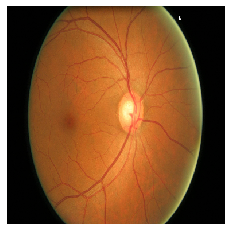

In [8]:
for img, label in train_ds.take(1):
    print(label)
    plt.imshow(img)
    plt.axis('off')
    print(np.max(img.numpy()))

In [9]:
ROTATE_ANGLE = 10/180 * math.pi

def image_augment(img, label):
    batch_size = tf.shape(img)[0]

    img = tf.image.random_flip_left_right(img)
    img = tfa.image.rotate(img, tf.random.uniform([batch_size], minval=-ROTATE_ANGLE, maxval=ROTATE_ANGLE)[0])
    
    img = tf.image.resize(img, [500, 500])
    img = tf.image.random_crop(img, [batch_size, IMG_DIM, IMG_DIM, 3])

    img = tfa.image.random_cutout(img, (100, 100))

    return img, label

In [10]:
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE).map(image_augment)
test_ds = test_ds.batch(BATCH_SIZE)

tf.Tensor(0.0, shape=(), dtype=float32)


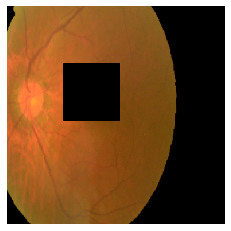

In [11]:
for img, label in train_ds.take(1):
    print(label[0])
    plt.imshow(img[0])
    plt.axis('off')

In [12]:
TF_HUB_MODEL = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'
hub_layer = hub.KerasLayer(TF_HUB_MODEL, trainable=False)

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build([None, IMG_DIM, IMG_DIM, 3])  # Batch input shape.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 16)                28688     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 17,702,521
Trainable params: 28,705
Non-trainable params: 17,673,816
_________________________________________________________________


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['acc']
)

In [15]:
history = model.fit(
    train_ds,
    epochs=1,
    validation_data=test_ds,
)

38/38 [==============================] - 22s 590ms/step - loss: 0.6933 - acc: 0.5075 - val_loss: 0.6828 - val_acc: 0.6333


In [16]:
hub_layer.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 16)                28688     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 17,702,521
Trainable params: 17,577,321
Non-trainable params: 125,200
_________________________________________________________________


In [17]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
38/38 [==============================] - 20s 533ms/step - loss: 0.6684 - acc: 0.6125 - val_loss: 0.6629 - val_acc: 0.6400
Epoch 2/10
38/38 [==============================] - 20s 534ms/step - loss: 0.6445 - acc: 0.6375 - val_loss: 0.6387 - val_acc: 0.6600
Epoch 3/10
38/38 [==============================] - 20s 537ms/step - loss: 0.6279 - acc: 0.6558 - val_loss: 0.6228 - val_acc: 0.6800
Epoch 4/10
38/38 [==============================] - 20s 534ms/step - loss: 0.6085 - acc: 0.6792 - val_loss: 0.6123 - val_acc: 0.6933
Epoch 5/10
38/38 [==============================] - 21s 541ms/step - loss: 0.5972 - acc: 0.6875 - val_loss: 0.6014 - val_acc: 0.7000
Epoch 6/10
38/38 [==============================] - 21s 545ms/step - loss: 0.5915 - acc: 0.6842 - val_loss: 0.5936 - val_acc: 0.7133
Epoch 7/10
38/38 [==============================] - 21s 541ms/step - loss: 0.5818 - acc: 0.6942 - val_loss: 0.5878 - val_acc: 0.7133
Epoch 8/10
38/38 [==============================] - 21s 543ms/step - 

In [18]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
38/38 [==============================] - 20s 531ms/step - loss: 0.5702 - acc: 0.7000 - val_loss: 0.5775 - val_acc: 0.7067
Epoch 2/10
38/38 [==============================] - 20s 529ms/step - loss: 0.5601 - acc: 0.7142 - val_loss: 0.5707 - val_acc: 0.7067
Epoch 3/10
38/38 [==============================] - 21s 543ms/step - loss: 0.5519 - acc: 0.7175 - val_loss: 0.5674 - val_acc: 0.7333
Epoch 4/10
38/38 [==============================] - 20s 532ms/step - loss: 0.5553 - acc: 0.7083 - val_loss: 0.5654 - val_acc: 0.7533
Epoch 5/10
38/38 [==============================] - 21s 543ms/step - loss: 0.5457 - acc: 0.7267 - val_loss: 0.5653 - val_acc: 0.7733
Epoch 6/10
38/38 [==============================] - 21s 543ms/step - loss: 0.5476 - acc: 0.7233 - val_loss: 0.5653 - val_acc: 0.7600
Epoch 7/10
38/38 [==============================] - 21s 540ms/step - loss: 0.5429 - acc: 0.7217 - val_loss: 0.5621 - val_acc: 0.7667
Epoch 8/10
38/38 [==============================] - 21s 541ms/step - 